In [8]:
import time
import matplotlib.pyplot as plt
import torch
import numpy as np
from laplacian_py import laplacian_solver
print(laplacian_solver.__dir__())

values = torch.zeros((300,300),dtype=torch.float32, device='cuda')
boundary = torch.zeros((300,300),dtype=torch.float32, device='cuda')
values[60:80, 60:80] = 5.0
boundary[60:80, 60:80] = 1.0;

# values[160:180, 160:180] = 5.0
# boundary[160:180, 160:180] = 1.0;

x = torch.stack([values, boundary], axis=2)

start = time.time()
for i in range(100000):
    laplacian_solver.solve(x)
# print(x)
end = time.time()
print(end - start)

# start = time.time()
# x = np.zeros((100,100),dtype=np.float32)
# for i in range(100000):
#     x = x + 1
# end = time.time()
# print(end - start)



['__name__', '__doc__', '__package__', '__loader__', '__spec__', 'solve', '__file__']
0.23512053489685059


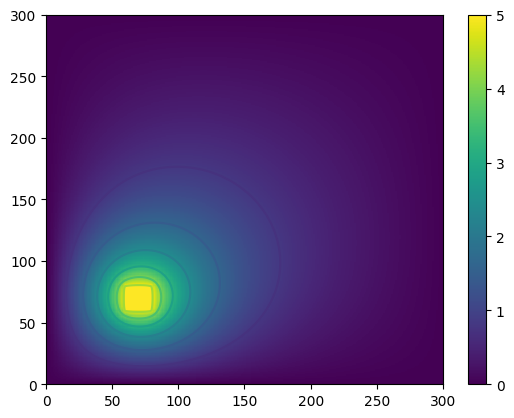

In [9]:

z = x.cpu().numpy()[:,:,0]
# z = boundary.cpu().numpy()
plt.pcolormesh(z)
# plt.pcolormesh(np.log(z+1))
plt.colorbar()
plt.contour(z)
plt.show()